In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import time
start = time.time()

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
train = pd.read_csv('./data/train.csv', low_memory=False)

In [32]:
nombres = {'subscription_type':  'sub_type',
           'start_station_name': 'ss_name',
           'end_station_name':   'es_name',
           'start_station_id':   'sid',
           'end_station_id':     'es_id',
           'start_date':         's_date',
           'end_date':           'e_date',
           'zip_code':           'z_code',
           'bike_id':            'b_id'}

train.rename(columns=nombres, inplace=True)

train.drop(['ss_name', 'es_name', 'z_code', 'id','e_date','es_id'], axis=1, inplace=True)
train.rename(columns={'sid':'id'}, inplace=True)

train['s_date'] = pd.to_datetime(train['s_date'], format='%m/%d/%Y %H:%M')

train['year'] = train['s_date'].map(lambda x:x.year)
train['month'] = train['s_date'].map(lambda x:x.month)
train['day'] = train['s_date'].map(lambda x:x.day)
train['weekday'] = train['s_date'].map(lambda x: x.weekday())
train['hour'] = train['s_date'].map(lambda x:x.hour)
train['minute'] = train['s_date'].map(lambda x:x.minute)

train['date'] = pd.DatetimeIndex(train['s_date']).normalize()

train = train.merge(pd.get_dummies(train.sub_type), left_index=True, right_index=True)
train.drop('sub_type', axis=1, inplace=True)

In [33]:
train = train[train.duration <= 21600]

In [34]:
stations = pd.read_csv('./data/station.csv', low_memory=False)

In [35]:
stations.drop(['name','lat','long','installation_date'], axis=1, inplace=True)

In [36]:
weather = pd.read_csv('./data/weather.csv', low_memory=False)

In [37]:
def zip_ciudad(zip_code):
    if zip_code == 95113: return 'San Jose'
    elif zip_code == 94301: return 'Palo Alto'
    elif zip_code == 94107: return 'San Francisco'
    elif zip_code == 94063: return 'Redwood City'
    else: return 'Mountain View'

In [38]:
rename = {'max_temperature_f': 'max_temp', 
          'mean_temperature_f': 'mean_temp', 
          'min_temperature_f': 'min_temp', 
          'max_dew_point_f': 'max_dew', 
          'mean_dew_point_f': 'mean_dew', 
          'min_dew_point_f': 'min_dew', 
          'max_humidity': 'max_hum', 
          'mean_humidity': 'mean_hum', 
          'min_humidity': 'min_hum', 
          'max_sea_level_pressure_inches': 'max_slp', 
          'mean_sea_level_pressure_inches': 'mean_slp', 
          'min_sea_level_pressure_inches': 'min_slp', 
          'max_visibility_miles': 'max_vis', 
          'mean_visibility_miles': 'mean_vis', 
          'min_visibility_miles': 'min_vis', 
          'max_wind_Speed_mph': 'max_wind', 
          'mean_wind_speed_mph': 'mean_wind', 
          'max_gust_speed_mph': 'max_gust', 
          'precipitation_inches': 'precipitation', 
          'cloud_cover': 'cloud', 
          'wind_dir_degrees': 'wind_dir', 
          'zip_code': 'z_code'
         }

weather.rename(columns=rename, inplace=True)

weather['date'] = pd.to_datetime(weather['date'], format='%m/%d/%Y')
weather.loc[weather.events == 'rain', 'events'] = 'Rain'
weather.loc[weather.events.isnull(), 'events'] = 'Normal'
weather = weather.merge(pd.get_dummies(weather.events), left_index=True, right_index=True)

#weather.loc[weather.precipitation == 'T', 'precipitation'] = 0
#weather.precipitation = weather.precipitation.astype(np.float64)
weather.drop(['precipitation'], axis=1, inplace=True)

weather['city'] = weather['z_code'].map(zip_ciudad)

for i in weather:
    weather.drop(weather.loc[weather[i].isnull()].index, inplace=True)

In [39]:
df = pd.merge(train, stations, how='inner', on='id')

In [40]:
df.shape

(547395, 15)

In [41]:
df = pd.merge(df, weather, how='inner', on=['date','city'])

In [42]:
df.shape

(530864, 42)

In [43]:
df = df.merge(pd.get_dummies(df.city), left_index=True, right_index=True)

In [44]:
df.drop(['s_date','date','events','z_code','city'], axis=1, inplace=True)

In [45]:
df.isnull().sum()

duration             0
id                   0
b_id                 0
year                 0
month                0
day                  0
weekday              0
hour                 0
minute               0
Customer             0
Subscriber           0
dock_count           0
max_temp             0
mean_temp            0
min_temp             0
max_dew              0
mean_dew             0
min_dew              0
max_hum              0
mean_hum             0
min_hum              0
max_slp              0
mean_slp             0
min_slp              0
max_vis              0
mean_vis             0
min_vis              0
max_wind             0
mean_wind            0
max_gust             0
cloud                0
wind_dir             0
Fog                  0
Fog-Rain             0
Normal               0
Rain                 0
Rain-Thunderstorm    0
Mountain View        0
Palo Alto            0
Redwood City         0
San Francisco        0
San Jose             0
dtype: int64

In [46]:
from sklearn.preprocessing import normalize
Y = df.duration.values
df = normalize(df.drop(['duration'], axis=1))

In [47]:
from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import SelectKBest
#from sklearn.decomposition import PCA
from sklearn.cross_decomposition import *
from sklearn.ensemble import * 
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.linear_model import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.gaussian_process import *
from sklearn.kernel_ridge import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.model_selection import *
from scipy.stats import randint as sp_randint

In [48]:
def scores_de_predictores_CV_5():
    for reg in regs:
        print regs[reg],np.mean(cross_val_score(reg, x, y, cv=5, scoring="neg_mean_squared_error", n_jobs=1) * -1)

In [49]:
x = df[:3000]
y = Y[:3000]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

fin
Linear            2.13468750662e+25
RandomForest      6156188.613
Bagging           6063236.64802
GrandientBoosting 5860338.65021
Logistic          2642756.57356
SVR               6011402.38017
TheilSen          4743983.21982
MLP               5720279.83031
SGD               5726053.32811
ElasticNet        5727124.42231
KernelRidge       5688548.60218
PLS               2.66851711907e+13
Huber             5893199.43796
PassiveAggressive 6004600.95639
BayesRidge        4728877.43876
RidgeCV           5546407.95699
RANSAC            3.84861894314e+24
GaussianProcess   66644979.7643
RNN               5727176.592
KNN               6014617.61939
LarsCV            4685548.36188
DecisionTree      9480110.32767
ExtraTrees        5715711.90249
AdaBoost          5776443.48068


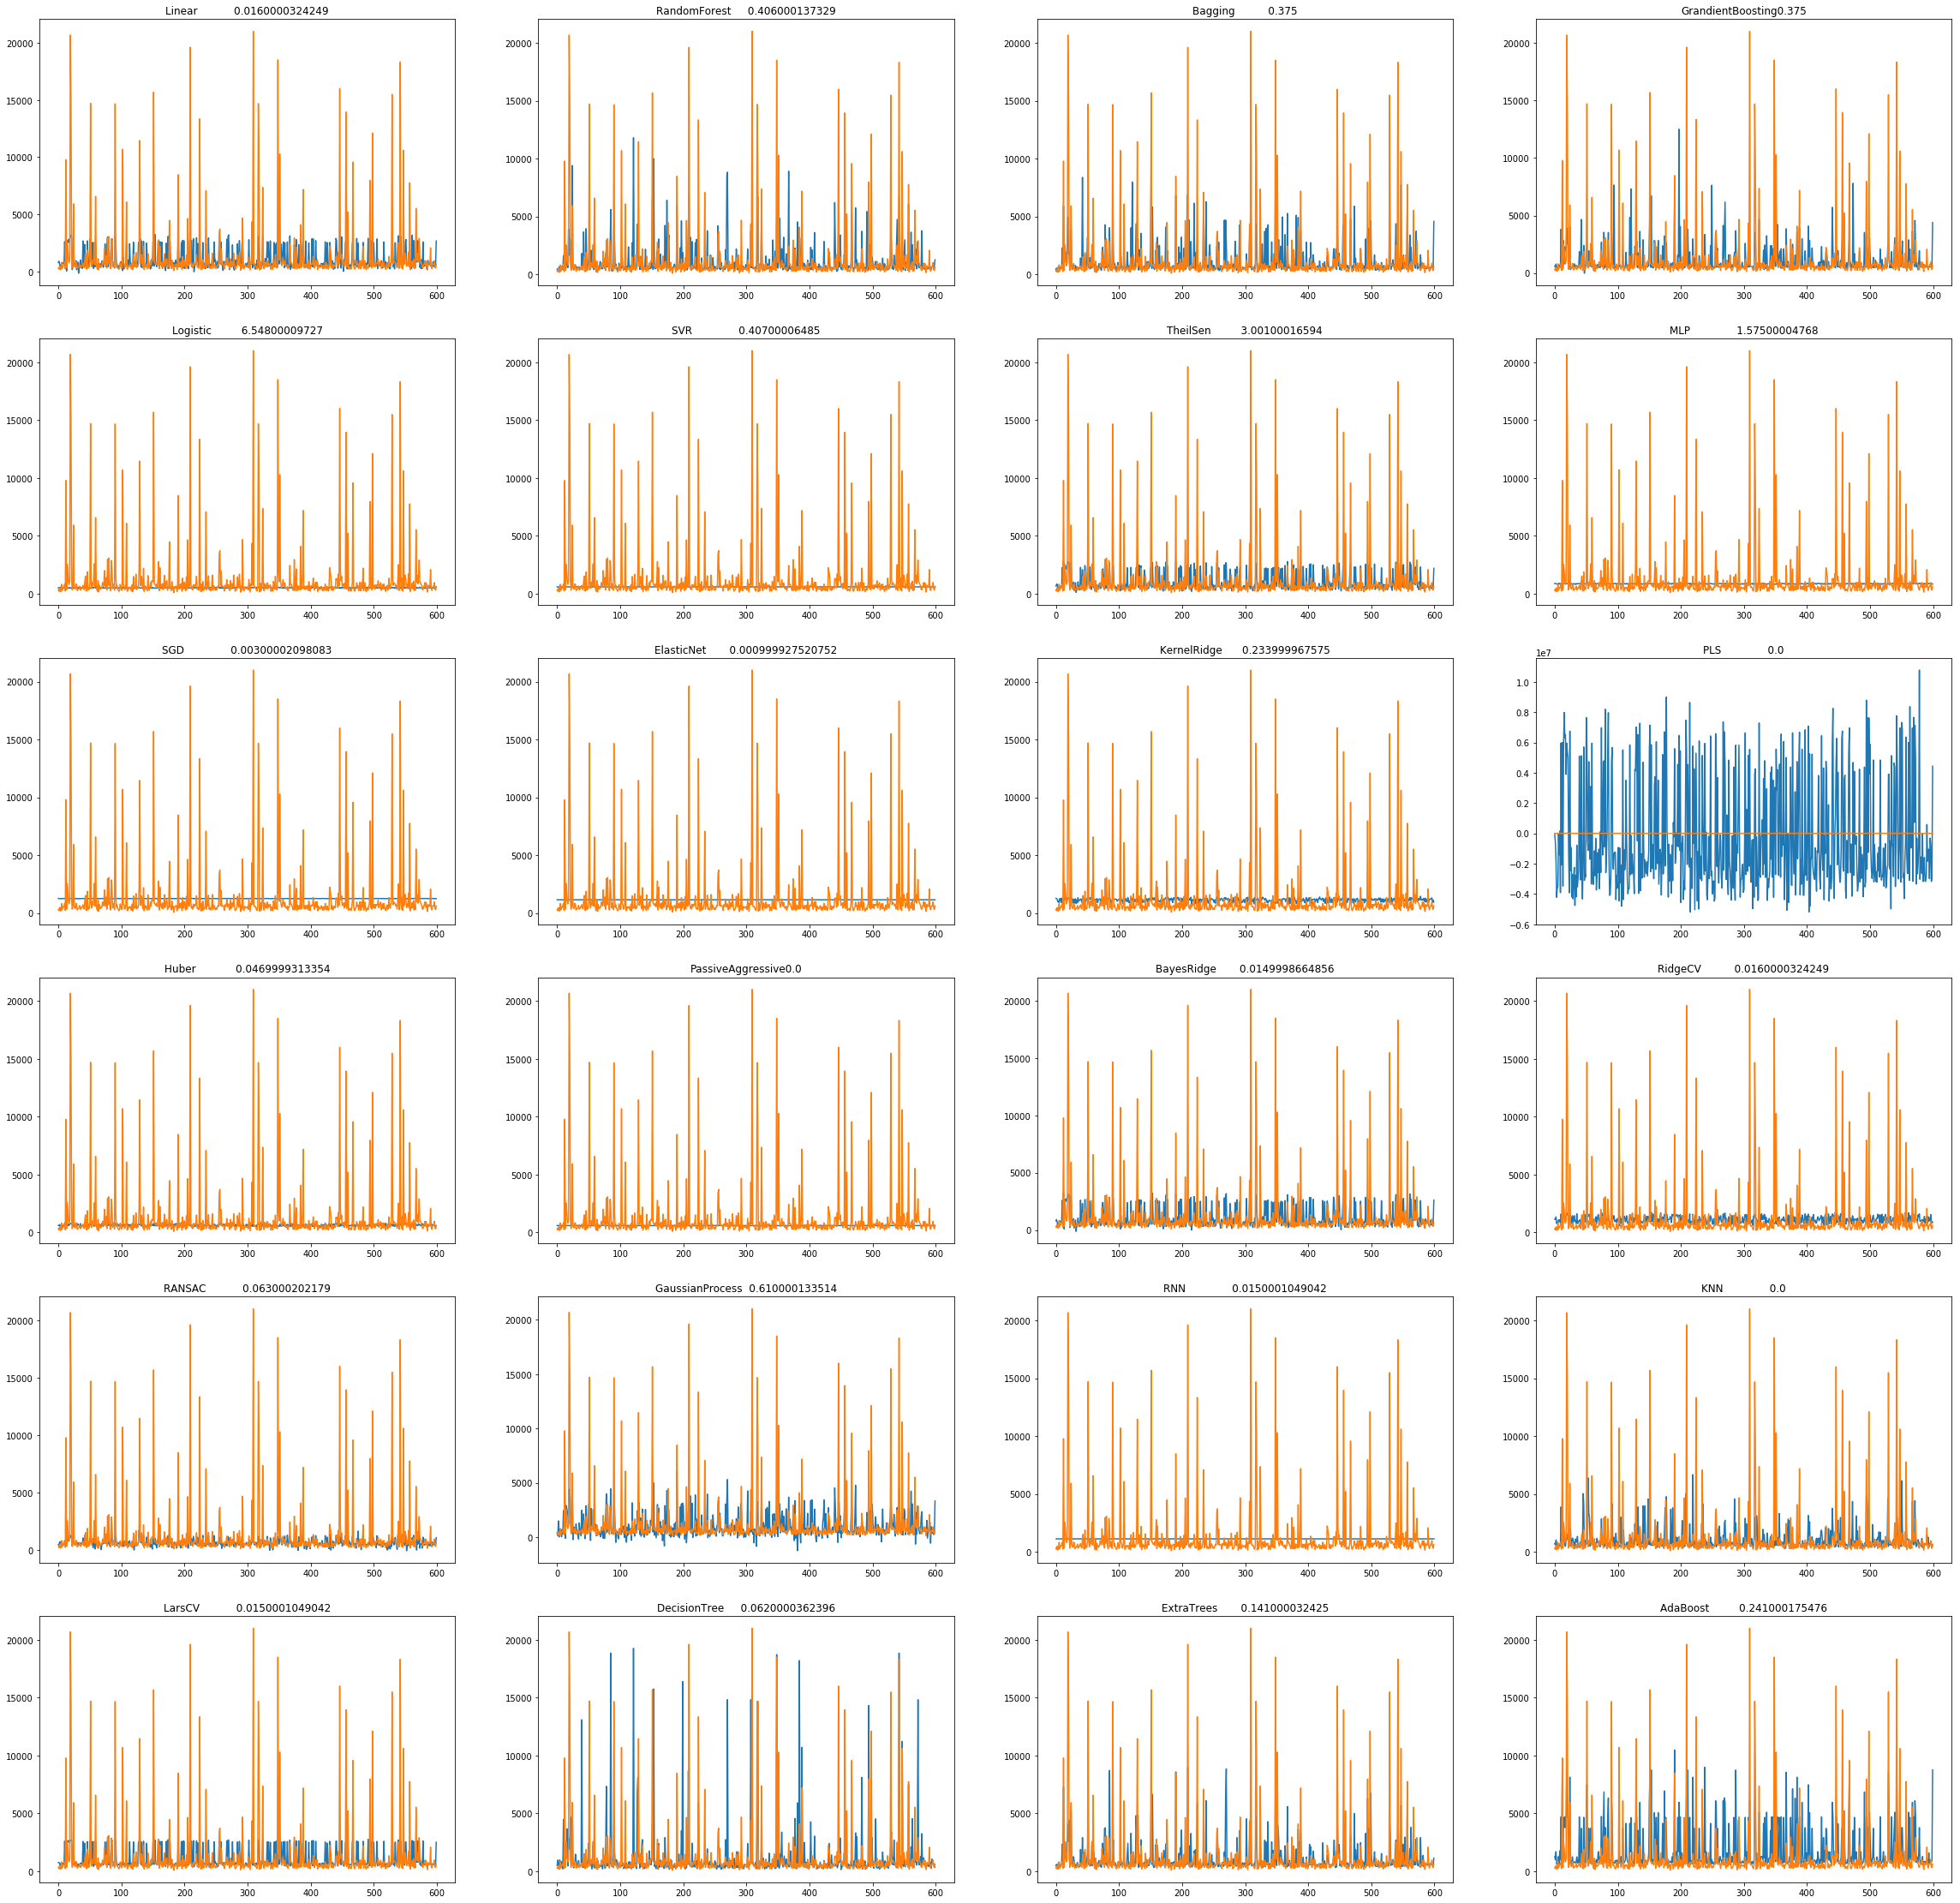

In [50]:
regs = {AdaBoostRegressor():         'AdaBoost         ',
        BaggingRegressor():          'Bagging          ',
        ExtraTreesRegressor():       'ExtraTrees       ',
        GradientBoostingRegressor(): 'GrandientBoosting',
        RandomForestRegressor():     'RandomForest     ',
        DecisionTreeRegressor():     'DecisionTree     ',
        HuberRegressor():            'Huber            ',
        LinearRegression():          'Linear           ',
        LogisticRegression():        'Logistic         ',
        PassiveAggressiveRegressor():'PassiveAggressive',
        RANSACRegressor():           'RANSAC           ',
        SGDRegressor():              'SGD              ',
        TheilSenRegressor():         'TheilSen         ',
        KernelRidge():               'KernelRidge      ',
        GaussianProcessRegressor():  'GaussianProcess  ',
        KNeighborsRegressor():       'KNN              ',
        RadiusNeighborsRegressor():  'RNN              ',
        MLPRegressor():              'MLP              ',
        PLSRegression():             'PLS              ',
        SVR():                       'SVR              ',
        ElasticNet():                'ElasticNet       ',
        BayesianRidge():             'BayesRidge       ',
        LarsCV():                    'LarsCV           ',
        RidgeCV():                   'RidgeCV          '
       }

def plots_de_predictores():
    plt.figure(figsize=(40, 40));
    i = 1
    for reg in regs:
        s1 = time.time()
        reg.fit(X_train, y_train)
        s2 = time.time()
        pred = reg.predict(X_test)
        score = mse(pred, y_test)
        plt.subplot(6, 4, i)
        plt.title(regs[reg] + str(s2-s1))
        plt.plot(pred)
        plt.plot(y_test)
        i += 1
    print 'fin'

plots_de_predictores()
scores_de_predictores_CV_5()

In [51]:
x = df[:100000]
y = Y[:100000]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [52]:
#Seleccionamos los mejores algoritmos y realizamos CV con 100000 registros.
regs = {
        BaggingRegressor():          'Bagging          ',
        ExtraTreesRegressor():       'ExtraTrees       ',
        DecisionTreeRegressor():     'DecisionTree     ',
       }
scores_de_predictores_CV_5()

ExtraTrees        2258943.67236
Bagging           2576464.79085
DecisionTree      6189251.33847


In [53]:
#GridSearch de ExtraTrees.
x = df[:5000]
y = Y[:5000]
params = {"n_estimators": list(range(10,31))}
ext = ExtraTreesRegressor()

clf = GridSearchCV(ext, param_grid=params)
clf.fit(x, y)
print "Mejores parametros:"
clf.best_params_

Mejores parametros:


{'n_estimators': 22}

In [54]:
#Comparacion de ExtraTrees con y sin parametros con 100000 registros.
x = df[:100000]
y = Y[:100000]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

regs = {
        ExtraTreesRegressor():       'ExtraTrees sin parametros       ',
        ExtraTreesRegressor(n_estimators=20):    'ExtraTrees con parametros     ',
       }

scores_de_predictores_CV_5()

ExtraTrees sin parametros        2260179.66251
ExtraTrees con parametros      2081287.55949


In [55]:
end = time.time()
print end-start

408.431999922
